# Sistema de Recomendação com Filtro

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import cv2 
from skimage.transform import resize
import os
from keras.preprocessing import image as kimage

import tensorflow as tf
from tensorflow.keras import models, layers, datasets, utils, preprocessing, Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [29]:
#from pylab import *
#import re

### Dados<a name="dados"></a>

In [2]:
x_validate = []
x_validate_name = []
for img in glob.glob("ela_validate/*.jpg"):
     if img[-11:] != "resaved.jpg" : 
        n= cv2.imread(img)
        x_validate.append(resize(n, (100,100),anti_aliasing=True, mode="reflect"))
        x_validate_name.append(img)

In [3]:
x_val=np.array(x_validate)
print(x_val.shape)

(55, 100, 100, 3)


### Modelo VGG16

In [9]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics.pairwise import cosine_similarity

In [10]:
vgg16 = VGG16(include_top=False, weights='imagenet')

In [11]:
vgg16_recommendation = vgg16.predict(x_val)

In [372]:
# Imagem a pesquisar
image=x_val[2]


image_reshaped=image.reshape(1,100,100,3)

# Filtrar as caracteristicas mais importantes da imagem
vgg16_image_recommendation = vgg16.predict(image_reshaped)

In [373]:
similarity_vgg16=[]

for i in range(len(x_val)):
    cos_lib_vgg16 = cosine_similarity(vgg16_image_recommendation.ravel().reshape(1,-1), vgg16_recommendation[i].ravel().reshape(1,-1))
    similarity_vgg16.append([cos_lib_vgg16,i])
    similarity_vgg16.sort(reverse=True)
 

In [374]:
pics_vgg16=[]

for i in range(5):
    pics_vgg16.append(similarity_vgg16[i][1])

print("VGG16:   ",pics_vgg16)

VGG16:    [2, 3, 26, 53, 37]


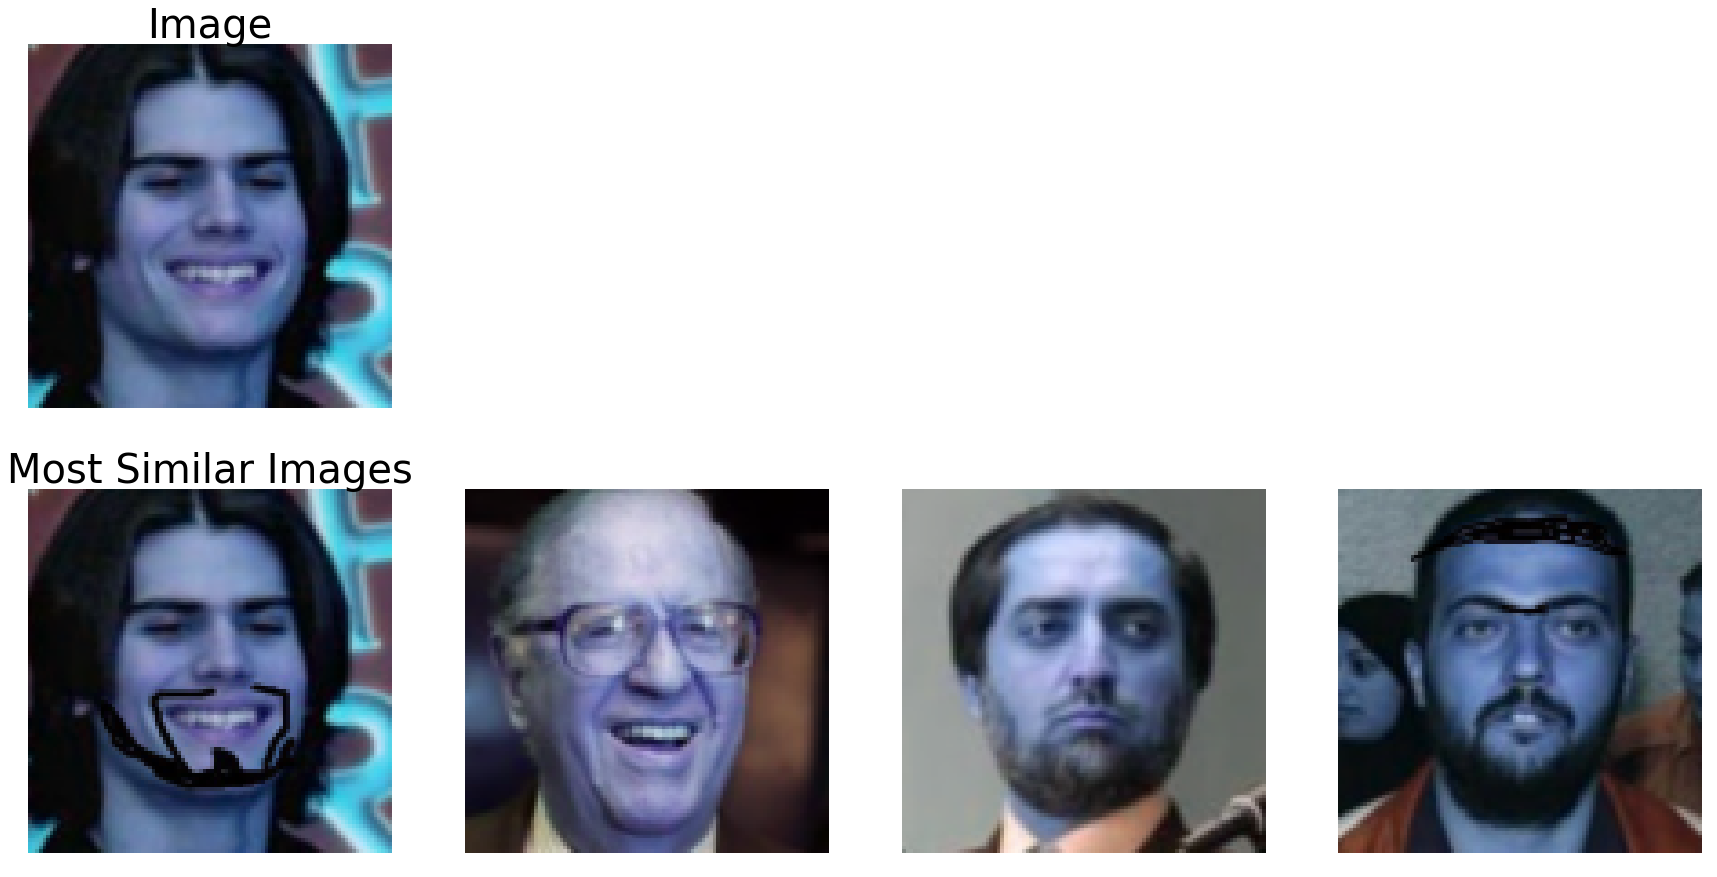

In [389]:
fig, ax = plt.subplots(2,4, figsize=(30, 15))

ax[0,0].imshow(image)
ax[0,0].set_title("Image",size=40)

ax[1,0].set_title("Most Similar Images",size=40)

for i in range(1,5):
   
        ax[0,i-1].axis('off')
        ax[1,i-1].imshow(x_val[pics_vgg16[i]])
        ax[1,i-1].axis('off')

### Modelo Error Level Analysis

In [376]:
from PIL import Image, ImageChops, ImageEnhance

In [377]:
model_filter = models.load_model("model_filter.h5")

In [378]:
# carregar os pesos do modelo guardado
model_filter.load_weights("model_filter_weights.h5")

In [379]:
# Error Level Analysis
def convert_to_ela_image(path, quality):
    filename = path
       
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [380]:
x_name=[]
for i in range(1,len(pics_vgg16)):
    x_name.append(x_validate_name[pics_vgg16[i]])
x_name

['ela_validate\\person_0001_mod.jpg',
 'ela_validate\\person_0013.jpg',
 'ela_validate\\person_0027.jpg',
 'ela_validate\\person_0018_mod.jpg']

In [381]:
x_ela=[]
for img in x_name:
    x_ela.append(np.array(convert_to_ela_image(img, 90).resize((100, 100))).flatten())


In [382]:
x_ela = np.array(x_ela)
x_ela = x_ela.reshape(-1, 100, 100, 3)

In [383]:
filter_predictions = model_filter.predict(x_ela)

In [384]:
filter_predictions

array([[1.00000000e+00, 0.00000000e+00],
       [1.01782225e-01, 8.98217738e-01],
       [1.01782225e-01, 8.98217738e-01],
       [1.00000000e+00, 4.70512657e-15]], dtype=float32)

In [385]:
filtered_img = [x for x in filter_predictions if x.argmax() == 1]
filtered_img

[array([0.10178223, 0.89821774], dtype=float32),
 array([0.10178223, 0.89821774], dtype=float32)]

In [386]:
index_filter=[]
for i in range (len(filter_predictions)):
    if filter_predictions[i].argmax() == 1:
            index_filter.append(i)
index_filter

[1, 2]

# Sistema de Recomendação com Filtro

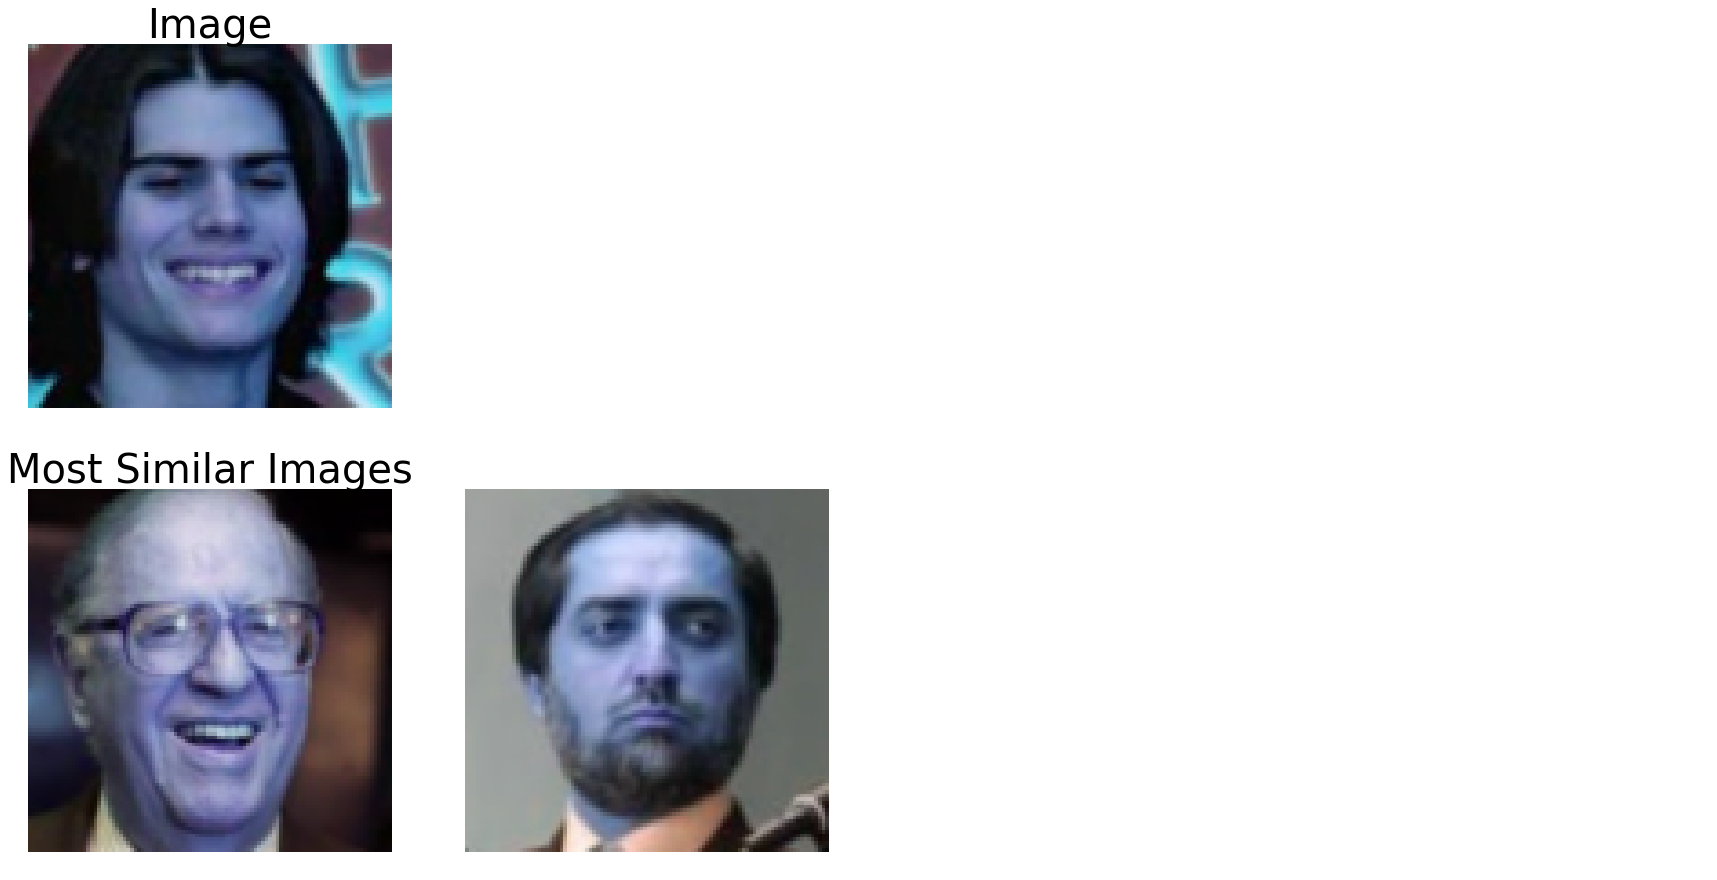

In [390]:
fig, ax = plt.subplots(2,4, figsize=(30, 15))

ax[0,0].imshow(image)
ax[0,0].set_title("Image",size=40)

ax[1,0].set_title("Most Similar Images",size=40)

for i in range (len(filter_predictions)):
    ax[0,i-1].axis('off')
    ax[1,i-1].axis('off')
        
    for j in range(len(filtered_img)):  
                ax[1,j].imshow(x_val[pics_vgg16[index_filter[j]+1]])
    
                 
    #if filter_predictions[i].argmax() == 1:
    #            ax[1,i-1].imshow(x_val[pics_vgg16[i+1]])   
    #            ax[0,j-1].axis('off')
    #            ax[1,j-1].axis('off')    